In [33]:
 #import sklearn 
 #print('The version of sklearn is {}'.format(sklearn.__version__))
 #!pip uninstall scikit-learn
 #!pip install scikit-learn==0.20.1

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!cat '/content/drive/MyDrive/Colab Notebooks/equal_groups.ipynb'
!cat '/content/drive/MyDrive/Colab Notebooks/equal_grouping.py'

{"nbformat":4,"nbformat_minor":0,"metadata":{"colab":{"name":"equal_groups.ipynb","provenance":[],"collapsed_sections":[],"authorship_tag":"ABX9TyM8T/L7MdrXE+orBjAjSa8g"},"kernelspec":{"name":"python3","display_name":"Python 3"},"language_info":{"name":"python"}},"cells":[{"cell_type":"code","metadata":{"id":"s3iNcHcIfCc8"},"source":["\"\"\"Equal Groups K-Means clustering utlizing the scikit-learn api and related\n","utilities.\n","\n","BSD 3-clause \"New\" or \"Revised\" License\n","\n","version 0.17.1\n","\"\"\"\n","\n","\n","import warnings\n","\n","import numpy as np\n","import scipy.sparse as sp\n","\n","from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin\n","#from sklearn.cluster import KMeans\n","from sklearn.cluster import k_means_\n","from sklearn.cluster import _k_means\n","from sklearn.externals.joblib import Parallel\n","from sklearn.externals.joblib import delayed\n","from sklearn.metrics.pairwise import euclidean_distances\n","from sklearn.utils.extmath

In [36]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
assert sys.version_info >= (3, 5)
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from sklearn.cluster import KMeans
#from equal_grouping import EqualGroupsKMeans
from equal_grouping import EqualGroupsKMeans

np.random.seed(42)
tf. random.set_seed(42)

In [37]:
M = 16
k = int(np.log2(M))
n = 16
training_snr = 20 #SNR Bob in dB
sample_size = 20_000
groups = 4
M_sec = 4

# PREPARING DATA FOR TRAINING AND TESTING

messages = np.random.randint(M, size= sample_size)
messages_2 = np.random.randint(M, size= sample_size)

one_hot_encoder = OneHotEncoder(categories=[range(M)], sparse=False)
data_oneH = one_hot_encoder.fit_transform(messages.reshape(-1,1))
data_oneH_2 = one_hot_encoder.fit_transform(messages_2.reshape(-1,1))
#data_oneH , data_oneH_2

In [38]:
## Function converts SNR(dB) to SNR ad eventually computes NOISE

def snr_to_noise(snrdb):
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [39]:
# CONSTRUCTING LAYERS FOR THE AUTOENCODERS OF BOB AND EVE

noise_std = snr_to_noise(training_snr)
noise_std2  = snr_to_noise(0)
noise_std_eve = snr_to_noise(2)

# custom functions to represent layers without weights
#norm = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded) #average power constraint
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))

channel_layer = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) )
channel_layer2 = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std2)))

add_layers = keras.layers.Lambda(lambda x: tf.add(x, tf.shape(channel_layer2)))
add_layers2 = keras.layers.Lambda(lambda x: tf.add(x, tf.shape(channel_layer)))

channel_layer_eve = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std_eve)))

# ENCODER_1
encoder_1 = keras.models.Sequential([
                                   keras.layers.InputLayer(input_shape=[M]),
                                   keras.layers.Dense(M, activation='elu'),
                                   keras.layers.Dense(2*n, activation=None),
                                   shape_layer,
                                   norm_layer])

# ENCODER_2
encoder_2 = keras.models.Sequential([
                                     keras.layers.InputLayer(input_shape=[M]),
                                     keras.layers.Dense(M, activation='elu'),
                                     keras.layers.Dense(2*n, activation=None),
                                     shape_layer,
                                     norm_layer])


# CHANNELS WITH NOISE
channel_1 = keras.models.Sequential([channel_layer, channel_layer2])
channel_2 = keras.models.Sequential([channel_layer2, channel_layer])

# channel_eve = keras.models.Sequential([channel_layer, channel_layer_eve])
channel_eve_1 = keras.models.Sequential([channel_1, channel_layer_eve])
channel_eve_2 = keras.models.Sequential([channel_2, channel_layer_eve])

# DECODER DESIGN
decoder_bob = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_bob_2 = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_eve = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_eve_2 = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

# AUTOENCODER DESIGN
autoencoder_input_1 = keras.models.Sequential([encoder_1, channel_1, decoder_bob])
#autoencoder_input_2 = keras.models.Sequential([encoder_2, channel, decoder_bob])
autoencoder_input_2 = keras.models.Sequential([encoder_2, channel_2, decoder_bob_2])
autoencoder_eve_1 = keras.models.Sequential([encoder_1, channel_eve_1, decoder_eve])
autoencoder_eve_2 = keras.models.Sequential([encoder_2, channel_eve_2, decoder_eve_2])


In [40]:
## FUNCTION TO RANDOMLY GIVE US A RANDOM BATCH OF OUR TRAIN DATA

def random_batch(X, batch_size = 32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx]

In [41]:
# UNSECURED TRAINING PARAMETERS

n_epochs = 5
batch_size = 100
n_steps = len(data_oneH) // batch_size


#learning_rate = 0.005
#global_step = 0
#decayed_lr = tf.compat.v1.train.exponential_decay(learning_rate,
#                                        global_step, 50,
#                                        0.9, staircase=True)

#opt = tf.train.AdamOptimizer(decayed_lr, epsilon=adam_epsilon)
#optimizer = keras.optimizers.Nadam(decayed_lr)
optimizer = keras.optimizers.Nadam(learning_rate=0.006)
loss_fn = keras.losses.categorical_crossentropy
mean_loss = keras.metrics.Mean()

In [42]:
## BER CALCULATOR

def B_Ber(input_msg, msg):
    pred_error = tf.not_equal(tf.argmax(msg,1), tf.argmax(input_msg,1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [43]:
## PLOT TO TEST ENCODING RESULTS

def test_encoding(M=16, n=1):
    inp = np.eye(M, dtype=int)
    inp_2 = np.eye(M, dtype=int)
    coding_1 = encoder_1.predict(inp)
    coding_2 = encoder_2.predict(inp_2)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding_1[:,0], coding_1[:,1], 'b.')
    plt.plot(coding_2[:,0], coding_2[:,1], '*r')
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [44]:
## PLOT FOR NOISY RECEIVED

def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:,1], 'b.')
    #plt.plot(rcvd_word_eve[:,0], rcvd_word_eve[:,1], 'b.')
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [45]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 100 == 0:
        print(template.format(step, epoch, mean_loss, B_Ber(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [46]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss, B_Ber(X_batch, y_pred)))

In [47]:
# TRAINING 2 INPUTS TOGETHER Bob

def train_both_inputs_bob(n_epochs=5, n_steps=20, alpha=0.5,  plot_encoding=True, only_decoder = False):
    for epoch in range(1, n_epochs+1):
       
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)

            with tf.GradientTape() as tape:
                y_pred_1 = autoencoder_input_1(X_batch_1, training=True)
                y_pred_2 = autoencoder_input_2(X_batch_2, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))

                loss_eqn = (1-alpha)*loss_1 + alpha*loss_2
               

            if only_decoder: 
                gradients = tape.gradient(loss_eqn, decoder_bob.trainable_variables + decoder_bob_2.trainable_variables)
                optimizer.apply_gradients(zip(gradients, decoder_bob.trainable_variables + decoder_bob_2.trainable_variables))

            else:
                 gradient = tape.gradient(loss_eqn, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables)
                 optimizer.apply_gradients(zip(gradient, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables))
              
            mean_loss = (loss_eqn)
            
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)
            #plot_loss(step, epoch, mean_loss, X_batch_2, y_pred_2, plot_encoding)
        #plot_batch_loss(epoch, mean_loss, X_batch_1, y_pred_1)
        #plot_batch_loss(epoch, mean_loss, X_batch_2, y_pred_2)


In [48]:
#TRAINING 2 INPUTS TOGETHER EVE

def train_both_inputs_eve(n_epochs=5, n_steps=20, plot_encoding=True, alpha=0.5):
    for epoch in range(1, n_epochs+1):
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))

        
        for step in range(1, n_steps+1):
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)

            with tf.GradientTape(persistent=True) as tape:                
                y_pred_1 = autoencoder_eve_1(X_batch_1, training=True)
                y_pred_2 = autoencoder_eve_2(X_batch_2, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))

                loss_eqn = (1-alpha)*loss_1 + alpha*loss_2


            gradients = tape.gradient(loss_eqn, decoder_eve.trainable_variables + decoder_eve_2.trainable_variables)
            optimizer.apply_gradients(zip(gradients, decoder_eve.trainable_variables + decoder_eve_2.trainable_variables))

            # gradients_2 = tape.gradient(loss_2, decoder_eve_2.trainable_variables)
            # optimizer.apply_gradients(zip(gradients_2, decoder_eve_2.trainable_variables))


            mean_loss = (loss_eqn)
            # mean_loss = (loss_1)
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)
            # plot_loss(step, epoch, mean_loss, X_batch_2, y_pred_2, plot_encoding)
        #plot_batch_loss(epoch, mean_loss, X_batch_1, y_pred_1)
        #plot_batch_loss(epoch, mean_loss, X_batch_2, y_pred_2)


In [49]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve 

def Test_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_1.predict(data)
        code_word_2 = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_2 = code_word_2 + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob_2
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve_1
        rcvd_word_eve_2 = rcvd_word_2 + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve_2

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)
        dcoded_msg_bob_2 = decoder_bob_2.predict(rcvd_word_2) #How decoder predicts data from encoder 2
        dcoded_msg_eve_2 = decoder_eve_2.predict(rcvd_word_eve_2)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)
        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob_2)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve_2)

    # test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)
    #test_noisy_codeword(dcoded_msg_bob)

    return (snr_range, bber_vec_bob), (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve), (snr_range, bber_vec_eve_2)
    #return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)


In [50]:
# try to plt the decoder sees

def Decoder_Constellation(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    #bber_vec_eve = [None] * len(snr_range)
    bber_vec_bob_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(7)
        code_word = encoder_1.predict(data)
        code_word_2 = encoder_2.predict(data)

        rcvd_word = code_word + code_word_2 + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob

        decoded_msg_bob = decoder_bob.predict(rcvd_word)

    test_noisy_codeword(rcvd_word)


In [51]:
# Test Data for Unsecured Encoding #This data is used to plot BER# Paper plots for only 1 of the autoencoders.

N_test = 150_000
test_msg = np.random.randint(M, size=N_test)
one_hot_encoder = OneHotEncoder(sparse=False, categories = [range(M)])
data_normal = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))


Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 0.04896, Batch_BER: 0.00000


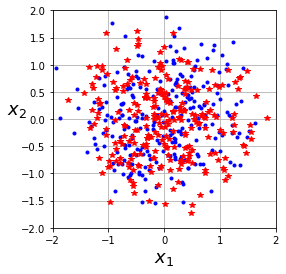

Iteration: 200, Epoch: 1, Loss: 0.01536, Batch_BER: 0.00000


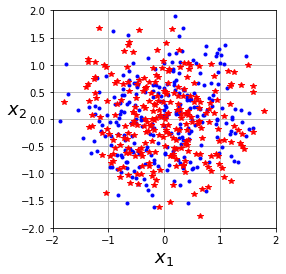

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 0.00947, Batch_BER: 0.00000


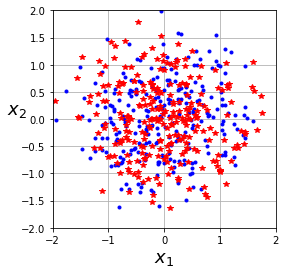

Iteration: 200, Epoch: 2, Loss: 0.00882, Batch_BER: 0.00000


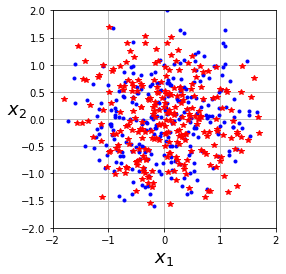

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 0.00798, Batch_BER: 0.00000


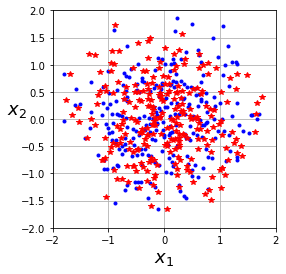

Iteration: 200, Epoch: 3, Loss: 0.00605, Batch_BER: 0.00000


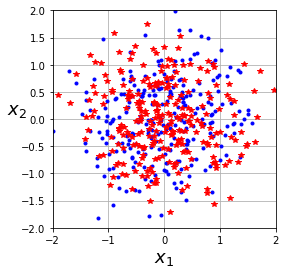

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 0.00542, Batch_BER: 0.00000


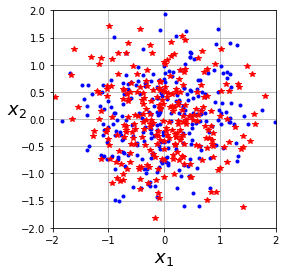

Iteration: 200, Epoch: 4, Loss: 0.01905, Batch_BER: 0.01000


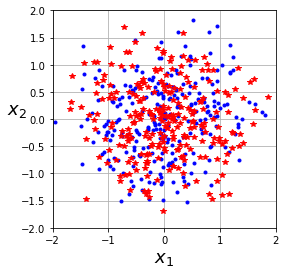

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 0.00272, Batch_BER: 0.00000


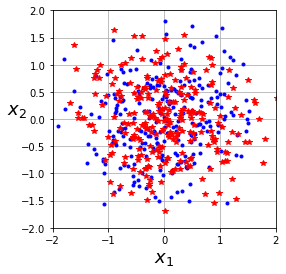

Iteration: 200, Epoch: 5, Loss: 0.00522, Batch_BER: 0.00000


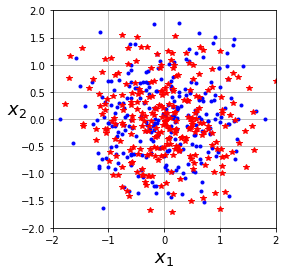

Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 0.10021, Batch_BER: 0.03000


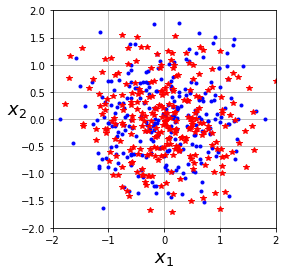

Iteration: 200, Epoch: 1, Loss: 0.09174, Batch_BER: 0.03000


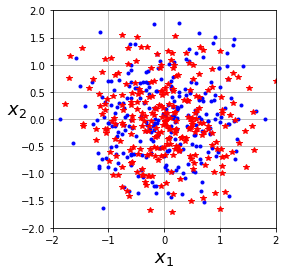

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 0.03102, Batch_BER: 0.01000


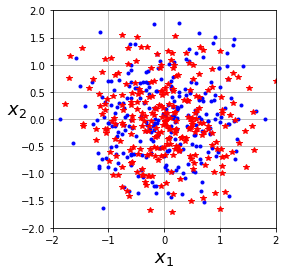

Iteration: 200, Epoch: 2, Loss: 0.09463, Batch_BER: 0.04000


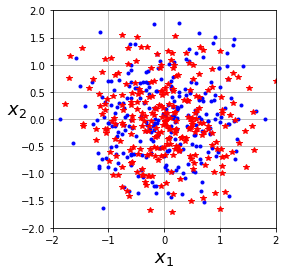

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 0.09057, Batch_BER: 0.03000


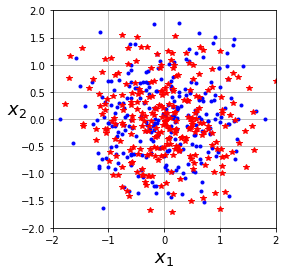

Iteration: 200, Epoch: 3, Loss: 0.14125, Batch_BER: 0.04000


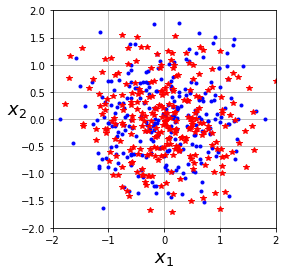

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 0.04539, Batch_BER: 0.02000


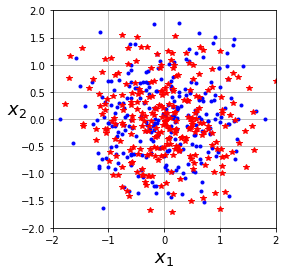

Iteration: 200, Epoch: 4, Loss: 0.04445, Batch_BER: 0.01000


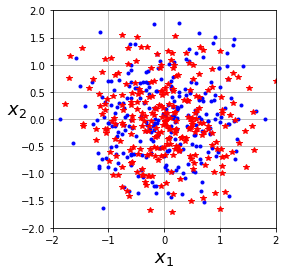

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 0.06474, Batch_BER: 0.02000


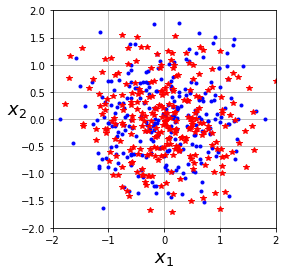

Iteration: 200, Epoch: 5, Loss: 0.08261, Batch_BER: 0.04000


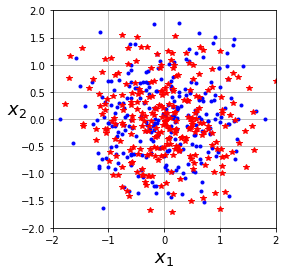

In [52]:
#TRAINING BOB AND EVE AND TESTING

train_both_inputs_bob(n_epochs, n_steps, alpha=0.1, plot_encoding = True, only_decoder = False)
train_both_inputs_eve(n_epochs, n_steps, plot_encoding=True, alpha=0.1)
bber_data_bob, bber_data_bob_2, bber_data_eve, bber_data_eve_2 = Test_AE(data_normal)

#Decoder_Constellation(data_normal)

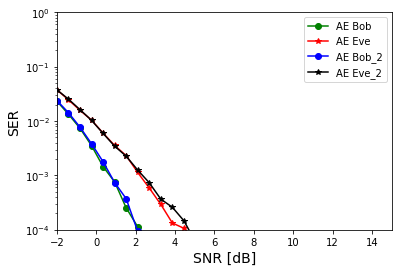

In [53]:
# PLOTTING BER FOR BOB AND EVE AFTER SECURED TRAINING

plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'go-')
plt.semilogy(bber_data_eve[0], bber_data_eve[1], 'r*-')
plt.semilogy(bber_data_bob_2[0], bber_data_bob_2[1], 'bo-')
plt.semilogy(bber_data_eve_2[0], bber_data_eve_2[1], 'k*-')



plt.gca().set_ylim(1e-4, 1)
plt.gca().set_xlim(-2, 15)

plt.xlabel('SNR [dB]', fontsize = 14)
plt.ylabel('SER', fontsize = 14, rotation=90)

#plt.legend(['AE Bob', 'AE Eve','Secured_AE Bob', 'Secured_AE Eve'],prop={'size': 10}, loc='best');
plt.legend(['AE Bob', 'AE Eve','AE Bob_2', 'AE Eve_2'],prop={'size': 10}, loc='best');

In [54]:

# KMEANS FROM EQUAL SIZE PY MODULE

def new_kmeans(M=16, groups=4, n=100):
    inp = np.eye(M, dtype=int)
    unit_codewords = encoder_1.predict(inp)
    kmeans = EqualGroupsKMeans(n_clusters=groups)
    kmeans.fit(unit_codewords.reshape(M, 2*n))
    return kmeans

def new_kmeans2(M=16, groups=4, n=100):
    inp_2 = np.eye(M, dtype=int)
    unit_codewords_2 = encoder_2.predict(inp_2)
    kmeans2 = EqualGroupsKMeans(n_clusters=groups)
    kmeans2.fit(unit_codewords_2.reshape(M, 2*n)) 
    return kmeans2

In [55]:
# Generation of Secured Matrix using kmeans_labels from new file

def secure_matrix(kmeans_labels, groups=4, M=16):
    sec_matrix = np.zeros((M,M))
    for j in range(groups):
        for i in range(M):
            if kmeans_labels[i]==j:
                for k in range(M):
                    if kmeans_labels[k] == j:
                        sec_matrix[i,k] = 1/groups;
    sec_matrix=tf.cast(sec_matrix, tf.float64)
    return sec_matrix

def secure_matrix2(kmeans2_labels, groups=4, M=16):
    sec_matrix2 = np.zeros((M,M))
    for j in range(groups):
        for i in range(M):
            if kmeans2_labels[i]==j:
                for k in range(M):
                    if kmeans2_labels[k] == j:
                        sec_matrix2[i,k] = 1/groups;
    sec_matrix2=tf.cast(sec_matrix2, tf.float64)
    return sec_matrix2

In [56]:
# # SECURED TRAINING 

# def train_Secure(kmeans_labels, n_epochs=5, n_steps=20, alpha=0.7, plot_encoding=True):

#     sec_matrix = secure_matrix(kmeans_labels, groups=4, M=16)
#     for epoch in range(1, n_epochs+1):
#         print('Trainig for Secrecy in Epochs: {}/{}'.format(epoch, n_epochs))
#         for step in range(1, n_steps+1):
#             x_batch = random_batch(data_oneH, batch_size)
#             x_batch_s = tf.matmul(x_batch, sec_matrix)

#             with tf.GradientTape() as tape:
#                 y_pred_bob = autoencoder_bob(x_batch, training=True)
#                 #y_pred_eve = autoencoder_eve(x_batch, training=False)
#                 y_pred_eve = autoencoder_eve(x_batch_s, training=True)

#                 loss_bob = tf.reduce_mean(loss_fn(x_batch, y_pred_bob))    
#                 loss_eve = tf.reduce_mean(loss_fn(x_batch_s, y_pred_eve))
#                 loss_sec =  (1-alpha)*loss_bob + alpha*loss_eve
#                 #loss_sec =  (alpha-1)*loss_bob - alpha*loss_eve

#             gradients = tape.gradient(loss_sec, autoencoder_bob.trainable_variables) 
#             optimizer.apply_gradients(zip(gradients, autoencoder_bob.trainable_variables)) 
#             mean_loss(loss_sec)
#             plot_loss(step, epoch, mean_loss, x_batch, y_pred_bob, plot_encoding)
#         plot_batch_loss(epoch, mean_loss, x_batch, y_pred_bob)


In [57]:
# SECURED TRAINING FOR MULTIPLE INPUTS (2)

def train_Secure(kmeans_labels, kmeans2_labels, n_epochs=5, n_steps=20, eps=0.7, beta=0.7, gamma=0.2, plot_encoding=True):

    sec_matrix = secure_matrix(kmeans_labels, groups=4, M=16)
    sec_matrix2 = secure_matrix2(kmeans2_labels, groups=4, M=16)

    for epoch in range(1, n_epochs+1):
        print('Trainig for Secrecy in Epochs: {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            x_batch_1 = random_batch(data_oneH, batch_size)
            x_batch_s_1 = tf.matmul(x_batch_1, sec_matrix)

            x_batch_2 = random_batch(data_oneH_2, batch_size)
            x_batch_s_2 = tf.matmul(x_batch_2, sec_matrix2)

            with tf.GradientTape(persistent=True) as tape:
                y_pred_bob_1 = autoencoder_input_1(x_batch_1, training=True)
                y_pred_eve_1 = autoencoder_eve_1(x_batch_s_1, training=True)

                y_pred_bob_2 = autoencoder_input_2(x_batch_2, training=True)
                y_pred_eve_2 = autoencoder_eve_2(x_batch_s_2, training=True)

                loss_bob_1 = tf.reduce_mean(loss_fn(x_batch_1, y_pred_bob_1))    
                loss_eve_1 = tf.reduce_mean(loss_fn(x_batch_s_1, y_pred_eve_1))

                loss_bob_2 = tf.reduce_mean(loss_fn(x_batch_2, y_pred_bob_2))
                loss_eve_2 = tf.reduce_mean(loss_fn(x_batch_s_2, y_pred_eve_2))

                loss_sec =  (1-eps)*(beta*(loss_bob_1) + (1-beta)*loss_bob_2) + eps*(gamma*(loss_eve_1) + (1-gamma)*loss_eve_2)
            
                # loss_sec =  beta*(loss_bob_1) + (1-beta)*loss_eve_1 
                # loss_sec_2 = gamma*(loss_bob_2) + (1-gamma)*loss_eve_2 

            gradients = tape.gradient(loss_sec, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables) 
            optimizer.apply_gradients(zip(gradients, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables)) 

            # mean_loss(loss_sec)
            # plot_loss(step, epoch, mean_loss, x_batch_1, y_pred_bob_1, plot_encoding) 


        #plot_batch_loss(epoch, mean_loss, x_batch, y_pred_bob)

In [58]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve 

def Test_Secure_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(3)
        code_word = encoder_1.predict(data)
        code_word_2 = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_2 = code_word_2 + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob_2
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve_1
        rcvd_word_eve_2 = rcvd_word_2 + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve_2

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)
        dcoded_msg_bob_2 = decoder_bob_2.predict(rcvd_word_2) #How decoder predicts data from encoder 2
        dcoded_msg_eve_2 = decoder_eve_2.predict(rcvd_word_eve_2)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)
        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob_2)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve_2)

    # test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)
    #test_noisy_codeword(dcoded_msg_bob)

    return (snr_range, bber_vec_bob), (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve), (snr_range, bber_vec_eve_2)
    #return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)


In [59]:
# # Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (Testing with normal data) #NOT CALLED YET

# def Test_Secure_AE(data):
#     snr_range = np.linspace(-2, 15, 30)
#     bber_vec_bob = [None] * len(snr_range)
#     bber_vec_eve = [None] * len(snr_range)

#     for db in range(len(snr_range)):
#         noise_std = snr_to_noise(snr_range[db])
#         noise_std_eve = snr_to_noise(7)
#         code_word = encoder.predict(data)

#         rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
#         rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

#         dcoded_msg_bob = decoder_bob.predict(rcvd_word)
#         dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

#         bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
#         bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)

#     #test_noisy_codeword(rcvd_word)
#     #test_noisy_codeword(rcvd_word_eve)

#     return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

Trainig for Secrecy in Epochs: 1/5
Trainig for Secrecy in Epochs: 2/5
Trainig for Secrecy in Epochs: 3/5
Trainig for Secrecy in Epochs: 4/5
Trainig for Secrecy in Epochs: 5/5
Training Both inputs in Epochs 1/3
Iteration: 100, Epoch: 1, Loss: 0.02774, Batch_BER: 0.01000
Iteration: 200, Epoch: 1, Loss: 0.07728, Batch_BER: 0.02000
Training Both inputs in Epochs 2/3
Iteration: 100, Epoch: 2, Loss: 0.03185, Batch_BER: 0.01000
Iteration: 200, Epoch: 2, Loss: 0.04111, Batch_BER: 0.03000
Training Both inputs in Epochs 3/3
Iteration: 100, Epoch: 3, Loss: 0.00946, Batch_BER: 0.00000
Iteration: 200, Epoch: 3, Loss: 0.01026, Batch_BER: 0.00000
Training Both inputs in Epochs 1/2
Iteration: 100, Epoch: 1, Loss: 0.15649, Batch_BER: 0.04000


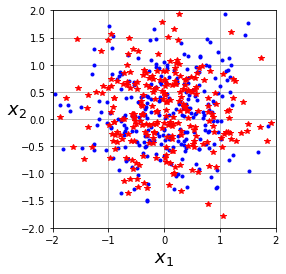

Iteration: 200, Epoch: 1, Loss: 0.21459, Batch_BER: 0.05000


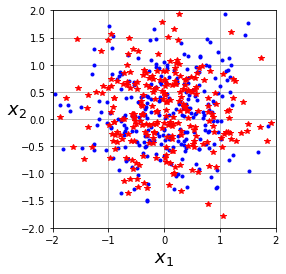

Training Both inputs in Epochs 2/2
Iteration: 100, Epoch: 2, Loss: 0.16383, Batch_BER: 0.06000


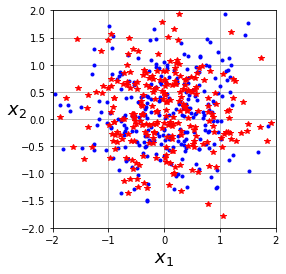

Iteration: 200, Epoch: 2, Loss: 0.27479, Batch_BER: 0.08000


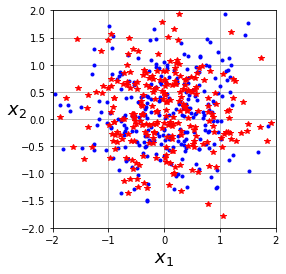

In [60]:
#TRAINING BOB AND EVE AND TESTING ~ USING modified KMEANS 

kmeans = new_kmeans(M, groups,n)
kmeans2 = new_kmeans2(M, groups, n)
# train_Secure(kmeans.labels_, n_epochs, n_steps, eps=0.8, beta=0.4, gamma=0.3, plot_encoding=True)

train_Secure(kmeans.labels_, kmeans2.labels_, n_epochs, n_steps, eps=0.9, beta=0.8, gamma=0.6, plot_encoding=True)
train_both_inputs_bob(n_epochs-2, n_steps, alpha=0.1, plot_encoding = False, only_decoder = True)
train_both_inputs_eve(n_epochs-3, n_steps, plot_encoding = True, alpha=0.1)

bber_sec_data_bob, bber_sec_data_bob_2, bber_sec_data_eve, bber_sec_data_eve_2 = Test_Secure_AE(data_normal)

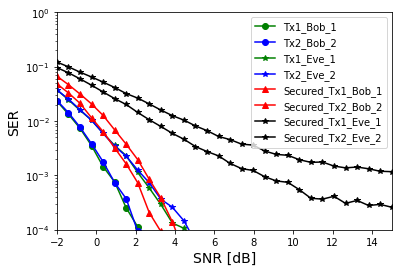

In [61]:
# PLOTTING BER FOR BOB AND EVE AFTER SECURED TRAINING

plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'go-')
plt.semilogy(bber_data_bob_2[0], bber_data_bob_2[1], 'bo-')
plt.semilogy(bber_data_eve[0], bber_data_eve[1], 'g*-')
plt.semilogy(bber_data_eve_2[0], bber_data_eve_2[1], 'b*-')

plt.semilogy(bber_sec_data_bob[0], bber_sec_data_bob[1], 'r^-')
plt.semilogy(bber_sec_data_bob_2[0], bber_sec_data_bob_2[1], 'r^-')
plt.semilogy(bber_sec_data_eve[0], bber_sec_data_eve[1], 'k*-')
plt.semilogy(bber_sec_data_eve_2[0], bber_sec_data_eve_2[1], 'k*-')


plt.gca().set_ylim(1e-4, 1)
plt.gca().set_xlim(-2, 15)

plt.xlabel('SNR [dB]', fontsize = 14)
plt.ylabel('SER', fontsize = 14, rotation=90)

plt.legend(['Tx1_Bob_1', 'Tx2_Bob_2', 'Tx1_Eve_1', 'Tx2_Eve_2', 'Secured_Tx1_Bob_1', 'Secured_Tx2_Bob_2', 'Secured_Tx1_Eve_1', 'Secured_Tx2_Eve_2'],prop={'size': 10}, loc='best');
# plt.legend(['AE Bob', 'AE Eve','AE Bob_2', 'AE Eve_2', 'Secured_AE Bob', 'Secured_AE Eve', 'Secured_AE Bob_2', 'Secured_AE Eve_2'],prop={'size': 10}, loc='best');


In [62]:

import csv 
with open('/content/drive/MyDrive/Colab Notebooks/Completed ~ DL PhySec/FileNew.csv', 'w', newline='') as file: 
    writer = csv.writer(file) 
    writer.writerow(['SNR', 'unsecured TX_1_Bob', 'unsecured TX_2_Bob','unsecured TX1_Eve','unsecured TX2_Eve','secured TX1_Bob', 'secured TX2_Bob', 'secured TX1_Eve', 'secured TX2_Eve'])
   
    for i in range(30):
      writer.writerow([bber_data_bob[0][i], np.array(bber_data_bob[1][i]), np.array(bber_data_bob_2[1][i]), np.array(bber_data_eve[1][i]), np.array(bber_data_eve_2[1][i]), np.array(bber_sec_data_bob[1][i]), np.array(bber_sec_data_bob_2[1][i]), np.array(bber_sec_data_eve[1][i]), np.array(bber_sec_data_eve_2[1][i])])


In [63]:
### LEFT AT 0.9 -- 0.9 -- 0.9 (eps, beta and gamma)